In [2]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

The firing rate equation. Leaky integrate and fire?

In [3]:
a = 270
b = 108
d = 0.154

def F(I):
    v = a*I - b
    return v / (1.0 - np.exp(-d*v))

Note the discontinuity at 0.4. Doesn't seem to affect simulations further on...

/Applications/Anaconda/anaconda/envs/mlbook/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


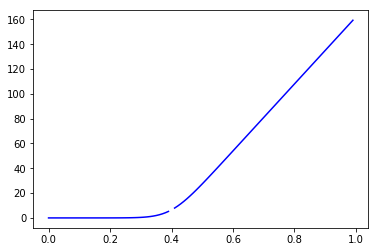

In [4]:
X = np.arange(0.0, 1.0, .01)
plt.plot(X, F(X), "b-")
plt.show()

The synaptic drive equations:

In [5]:
gamma = 0.641
phi = 1.0
timeconstant = 100

def dsdt(I, s):
    f = F(I) / 1000.0
    return phi*(f*gamma*(1.0-s) - s/timeconstant)

Input has noise given by 'Ornstein-Uhlenbeck process', and have a graph of it too:

In [6]:
I0 = 0.3255
rho0 = 2
noise_amplitude = 0.02

def dIbdt(Ib):
    v = -(Ib - I0) / rho0 + np.random.normal() * np.sqrt(rho0 * noise_amplitude**2.0)
    return v / rho0

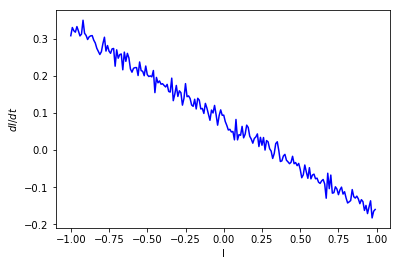

In [7]:
X = np.arange(-1, 1, .01)
y = [dIbdt(x) for x in X]
plt.plot(X, y, "b-")
plt.xlabel('I')
plt.ylabel(r'$dI/dt$')
plt.show()

The code to run a simulation over 3000 millisecs:

In [14]:
def muSequence(muChanges):
    mus = []
    for muChange in muChanges:
        muTimesteps = muChange[0]
        muValue = muChange[1]
        mus.extend([muValue] * muTimesteps)
    return mus

def muPulse3000(mu):
    return muSequence([(500, 0), (1000, mu), (1500, 0)])

In [18]:
gE = 0.2609
gI = 0.0497
gext = 0.00052

def simulateit(MU1, MU2):
    np.random.seed()
    vals = []
    
    s1 = 0.1
    s2 = 0.1
    Ib1 = 0
    Ib2 = 0
    totalTime = len(MU1)
    
    for t in range(0, totalTime):
        mu1 = MU1[t] 
        mu2 = MU2[t]
        Ib1 = Ib1 + dIbdt(Ib1)
        Ib2 = Ib2 + dIbdt(Ib2)
        i1 = gE*s1 - gI*s2 + Ib1 + gext*mu1
        i2 = gE*s2 - gI*s1 + Ib2 + gext*mu2
        r1 = F(i1)
        r2 = F(i2)
        s1 = s1 + dsdt(i1, s1)
        s2 = s2 + dsdt(i2, s2)
        vals.append([t, mu1, mu2, i1, i2, r1, r2, s1, s2])
        
    return np.array(vals).transpose()

Run a simulation, plot mu (the input), i1 and i2, r1 and r2, s1 and s2, and the two phase diagrams.

In [77]:
def plotes(timesteps, s1, s2, label1, label2, ylabel):
    plt.plot(timesteps, s1, "b-", label=label1, alpha=0.7)
    plt.plot(timesteps, s2, "r-", label=label2, alpha=0.7)
    plt.ylabel(ylabel)
    plt.legend(loc="upper left", fontsize=14)

def plotMus(timesteps, mu1, mu2):
    plotes(timesteps, mu1, mu2, r'$\mu_1$', r'$\mu_1$', r'$\mu_i$')
    
def plotRs(timesteps, r1, r2):
    plotes(timesteps, r1, r2, r'$r_1$', r'$r_1$', r'$r_i$')

def plotIs(timesteps, i1, i2):
    plotes(timesteps, i1, i2, r'$i_1$', r'$i_1$', r'$i_i$')
    
def plotSs(timesteps, s1, s2):
    plotes(timesteps, s1, s2, r'$s_1$', r'$s_1$', r'$s_i$')
    
def plotPhase(s1, s2, xlabel, ylabel, title):
    plt.plot(s1, s2, '-+', alpha=0.08)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
def plotRPhase(r1, r2):
    plotPhase(r1, r2, r'$r_1$', r'$r_2$', r'Phase space: $r_1$ vs $r_2$')
    
def plotSPhase(s1, s2):
    plotPhase(s1, s2, r'$s_1$', r'$s_2$', r'Phase space: $s_1$ vs $s_2$')


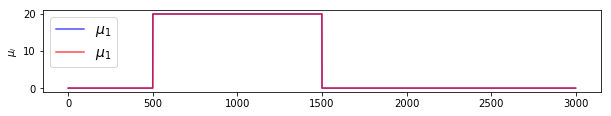

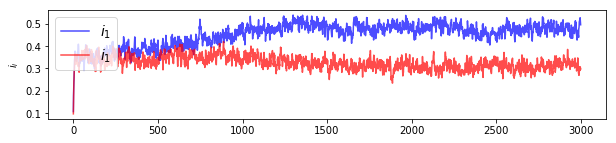

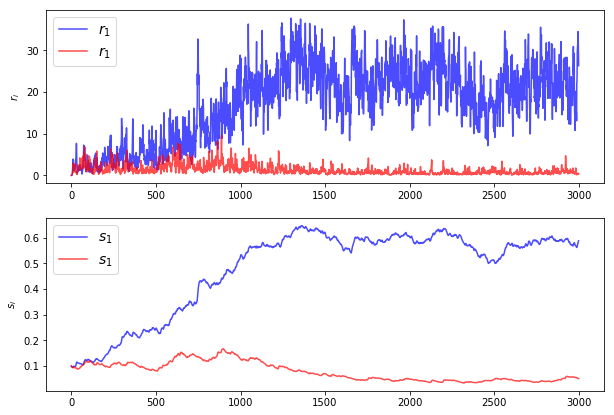

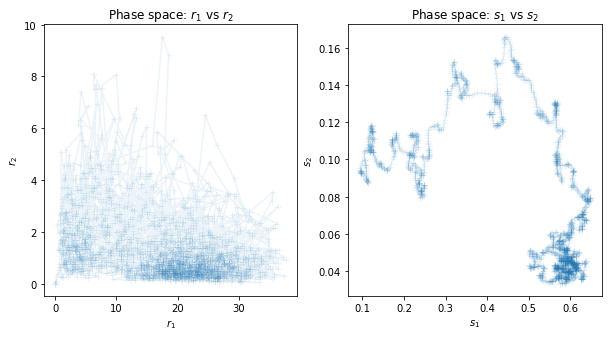

In [78]:
k = simulateit(muPulse3000(20), muPulse3000(20))

timesteps = k[0]
mu1 = k[1]
mu2 = k[2]
i1 = k[3] 
i2 = k[4] 
r1 = k[5] 
r2 = k[6] 
s1 = k[7] 
s2 = k[8] 

plt.figure(figsize=(10,1.5))
plotMus(timesteps, mu1, mu2)

plt.figure(figsize=(10,2))
plotIs(timesteps, i1, i2)

plt.figure(figsize=(10,7))
plt.subplot(211)
plotRs(timesteps, r1, r2)

plt.subplot(212)
plotSs(timesteps, s1, s2)

plt.show()


plt.figure(figsize=(10, 5))

plt.subplot(121)
plotRPhase(r1, r2)

plt.subplot(122)
plotSPhase(s1, s2)
           
plt.show()

Now do a bunch of simulations - we can see that it's about 50/50 whether each neural assembly wins

In [79]:
r1wins = 0
r2wins = 0
for i in range(0, 500):
    k = simulateit(muPulse3000(20), muPulse3000(20))
    r1 = k[5]
    r2 = k[6]
    if r1[2500] > r2[2500]:
        r1wins += 1
    else:
        r2wins += 1
print ('R1 wins: ', r1wins, '(', r1wins/500, ')   R2 wins: ', r2wins, '(', r2wins/500, ')')

R1 wins:  252 ( 0.504 )   R2 wins:  248 ( 0.496 )


An aside: see what it takes to make the system 'change its mind'...

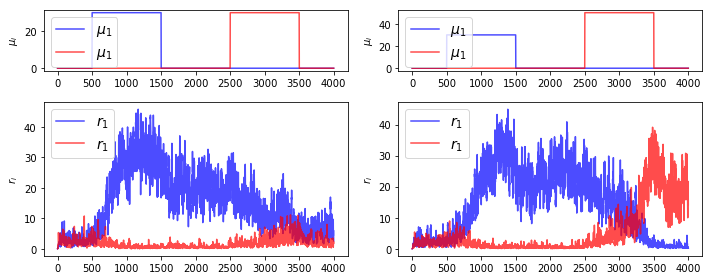

In [86]:
mu1Pulses = [muSequence([(500, 0), (1000, 30), (2500, 0)]), muSequence([(500, 0), (1000, 30), (2500, 0)])]
mu2Pulses = [muSequence([(2500, 0), (1000, 30), (1000, 0)]), muSequence([(2500, 0), (1000, 50), (1000, 0)])]

plt.figure(figsize=(10, 4))

for i in range(0, 2):
    k = simulateit(mu1Pulses[i], mu2Pulses[i])

    timesteps, mu1, mu2, r1, r2 = k[0], k[1], k[2], k[5], k[6]

    plt.subplot2grid((3, 2), (0, i), rowspan=1)
    plotMus(timesteps, mu1, mu2)

    plt.subplot2grid((3, 2), (1, i), rowspan=2)
    plotRs(timesteps, r1, r2)

plt.tight_layout()
plt.show()

Task 2: Psychometric function of coherence level

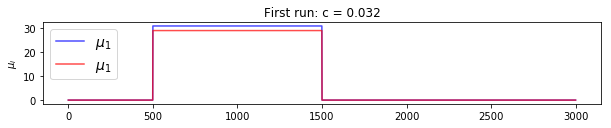

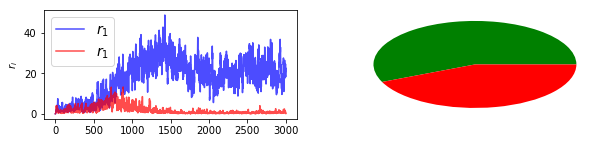

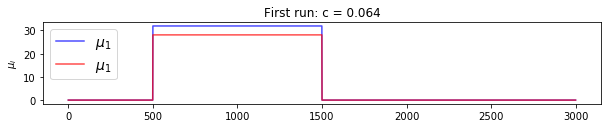

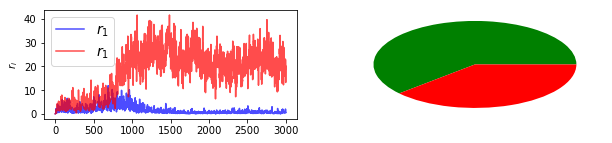

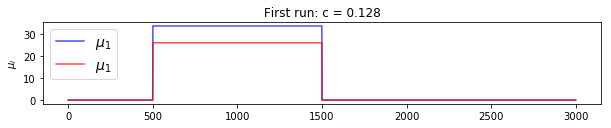

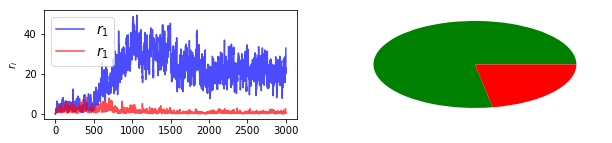

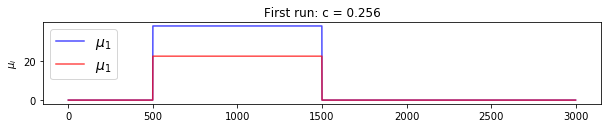

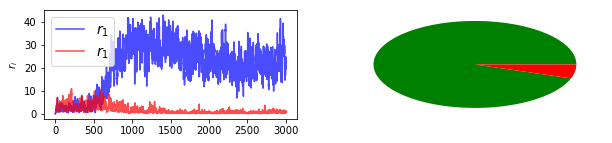

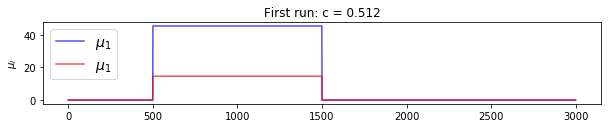

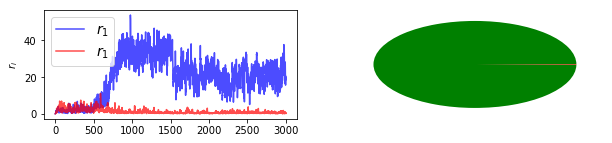

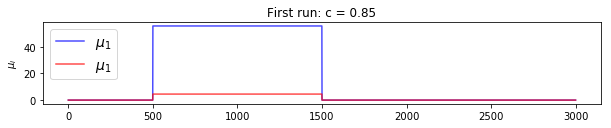

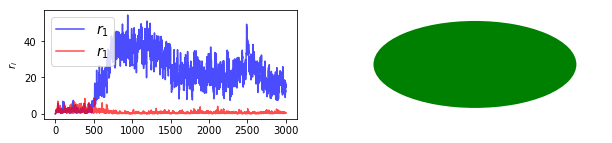

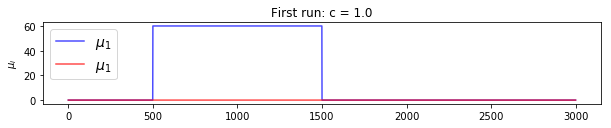

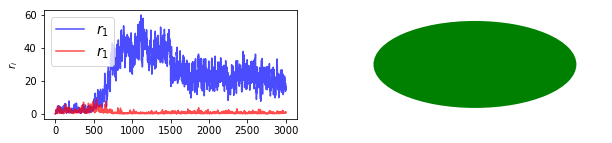

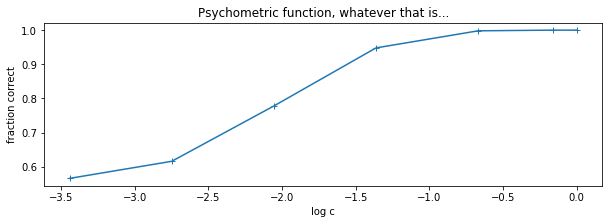

In [120]:
c_levels = [ 0.032, 0.064, 0.128, 0.256, 0.512, 0.85, 1.0 ]
fraction_correct_decisions = []
num_trials = 500
nc = len(c_levels)
for i, c in enumerate(c_levels):
    mu1v = 30.0 * (1.0 + c)
    mu2v = 30.0 * (1.0 - c)
    mu1Pulses = muSequence([(500, 0), (1000, mu1v), (1500, 0)])
    mu2Pulses = muSequence([(500, 0), (1000, mu2v), (1500, 0)])
    
    num_correct = 0
    
    for n in range(0, num_trials):
        k = simulateit(mu1Pulses, mu2Pulses)

        timesteps, mu1, mu2, r1, r2 = k[0], k[1], k[2], k[5], k[6]
        correct = (r1[2000] > r2[2000]) if mu1v > mu2v else (r1[2000] < r2[2000])
        num_correct = num_correct + (1 if correct else 0)
        
        if n == 0:
            plt.figure(figsize=(10,1.5))
            plotMus(timesteps, mu1, mu2)
            plt.title('First run: c = ' + str(c))

            plt.figure(figsize=(10,2))
            plt.subplot(121)
            plotRs(timesteps, r1, r2)

    
    fraction_correct = num_correct / num_trials
    fraction_correct_decisions.append(fraction_correct)
     
    plt.subplot(122)
    plt.pie([fraction_correct, 1.0-fraction_correct], colors=['g', 'r'])
   
#plt.tight_layout()
plt.show()
    
plt.figure(figsize=(10,3))

log_c_levels = np.log(c_levels)
plt.plot(log_c_levels, fraction_correct_decisions, "+-")
plt.ylabel('fraction correct')
plt.xlabel('log c')
plt.title('Psychometric function, whatever that is...')
plt.show()